<a href="https://colab.research.google.com/github/dadecampo/CVDeepLearning/blob/main/wGrapesFasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies and 
!pip install albumentations
!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.15.2
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./


!wget -O data.zip https://zenodo.org/record/6757555/files/wGrapeUNIPD-DL%20dataset.zip?download=1
!unzip data.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'vision'...
remote: Enumerating objects: 332260, done.
remote: Counting objects: 100% (48135/48135), done.
remote: Compressing objects: 100% (633/633), done.
remote: Total 332260 (delta 47649), reused 47849 (delta 47483), pack-reused 284125
Receiving objects: 100% (332260/332260), 670.23 MiB | 39.26 MiB/s, done.
Resolving deltas: 100% (305830/305830), done.
/content/vision
Note: switching to 'v0.15.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config vari

In [2]:

!rm content/wGrapeUNIPD-DL\ dataset/Calibrated_Images/without_Conting/Chardonnay_BBCH75_20_06_20/_DSC8819.jpg
!rm content/wGrapeUNIPD-DL\ dataset/Calibrated_Images/without_Conting/Chardonnay_BBCH75_20_06_20/_DSC8819.txt


rm: cannot remove 'content/wGrapeUNIPD-DL dataset/Calibrated_Images/without_Conting/Chardonnay_BBCH75_20_06_20/_DSC8819.jpg': No such file or directory
rm: cannot remove 'content/wGrapeUNIPD-DL dataset/Calibrated_Images/without_Conting/Chardonnay_BBCH75_20_06_20/_DSC8819.txt': No such file or directory


In [32]:
import os
import cv2
import numpy as np
import torch
from PIL import Image
import glob
import torchvision.transforms as T
import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from albumentations.core.composition import Compose
from albumentations.pytorch.transforms import ToTensorV2

from albumentations.augmentations.transforms import HorizontalFlip
import random

EPOCH = 5
BATCH_SIZE = 10


def get_transform(train):
  if train:
    return Compose(
      [
        HorizontalFlip(p=0.5),
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return Compose(
      [
      ToTensorV2(p=1.0)
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )


In [33]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [34]:
from PIL import Image
def resize_image(src_img, size=(800,800), bg_color="white"): 
    

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)

    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)

    # Paste the rescaled image onto the new centered background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))

    # return the resized image
    return new_image

In [35]:

class GrapeDataset(torch.utils.data.Dataset):
    def __init__(self, root, width, height, transforms = None):
        self.transforms = transforms
        self.root = root

        self.width = width
        self.height = height

        self.imgs=[]
        boxes_files=[]
        for root, dirs, files in os.walk(self.root):
            for file in files:
                if file.endswith(".txt") and not file.startswith("_counting"):
                    boxes_files.append(os.path.join(root, file))
                if file.endswith(".jpg") or file.endswith(".JPG")  :
                    self.imgs.append(os.path.join(root, file))
                if file.startswith("_counting"):
                   self.conting_file = os.path.join(root, "_counting.txt")
        self.imgs = sorted(self.imgs)
        boxes_files = sorted(boxes_files)
        self.boxes = boxes_files

    def __getitem__(self, idx):
        # get image and boxes
        img_path = self.imgs[idx]
        box_path = self.boxes[idx]
        # image elaboration
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0

        height, width, _ = img.shape
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        labels=[]
        boxes=[]
        with open(box_path) as f:
            for line in f:
                labels.append(1)

                elems=[float(x) for x in line.split(' ')]

                x_center = int(elems[1] * width)
                y_center = int(elems[2] * height)
                box_wt = int(elems[3] * width)
                box_ht = int(elems[4] * height)

                x_min = max(0.0, x_center - box_wt/2)
                x_max  = min(width, x_center + box_wt/2)
                y_min = max(0.0, y_center - box_ht/2)
                y_max  = min(height, y_center + box_ht/2)

                   

                boxes.append([x_min, y_min, x_max, y_max])

        iscrowd = None
        if len(boxes)!=0:
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          labels= torch.as_tensor(labels, dtype=torch.int64)
          iscrowd= torch.zeros((boxes.shape[0],),dtype=torch.int64)
          area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        else:
          area = torch.tensor(0)
          boxes.append([0, 0, 1, 1])
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          labels= torch.as_tensor(labels, dtype=torch.int64)
          labels = labels.unsqueeze(0)
          iscrowd = torch.zeros((boxes.shape[0],),dtype=torch.int64)


        target={}
        target["boxes"] = boxes
        target["area"] = area
        target["labels"]= labels
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img,
                                bboxes = target['boxes'],
                                labels = labels)
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img, target

    def __len__(self):
        return len(self.imgs)



In [36]:
    
def plot_img_bbox(img, target, prediction):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, ax = plt.subplots(2,1)
  fig.set_size_inches(5,5)
  img=img.permute(1,2,0)
  ax[0].imshow(img)
  ax[1].imshow(img)

  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax[0].add_patch(rect)

  for box in (prediction['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax[1].add_patch(rect)
  plt.show()
    

In [67]:
import time
from tqdm.notebook import tqdm

def train_epoch(model, optimizer, data_loader, device, epoch):
  model.train()

  j=0
  loss_dict ={}
  for i, (images, targets) in (tepoch := tqdm(enumerate(data_loader), unit="batch", total=len(data_loader))):
      tepoch.set_description(f"Epoch {epoch}")
      if j<BATCH_SIZE:
          # Step 1: send the image to the required device.
          # Images is a list of B images (where B = batch_size of the DataLoader).
          images = list(img.to(device) for img in images)
          # Step 2: send each target to the required device
          # Targets is a dictionary of metadata. each (k,v) pair is a metadata
          # required for training.
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

          model_time = time.time()
          loss_dict.update(model(images, targets))
          model_time = time.time() - model_time
          j+=1
          # Step 3. backward on loss.
          # Normally, you would obtain the loss from the model.forward()
          # and then just call .bacward() on it.
          # In this case, for each task, you have a different loss, due to
          # different error metrics adopted by the tasks.
          # One typical approach is to combine all the losses to one single loss,
          # and then then backward that single loss.
          # In this way you can adjust the weight of the different tasks,
          # multiplying each loss for a hyperparemeter.
          # E.G.:
          #       final_loss = loss_1 + gamma*(alpha*loss_2 + beta*loss_3)
          # In this case, we want to sum up all the losses.
      else:
          losses = sum(loss for loss in loss_dict.values())
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
          loss_dict ={}
          j=0
          tepoch.set_postfix(loss=losses.item())
          

      

In [ ]:
import random
import os
import cv2
import numpy as np
import torch
from PIL import Image
import glob
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torchvision import transforms as torchtrans
from engine import train_one_epoch, evaluate
import utils
import transforms as T

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
files_dir = "/content/wGrapeUNIPD-DL dataset/Calibrated_Images"

if __name__ == '__main__':
    # use our dataset and defined transformations
    dataset = GrapeDataset(files_dir, 800, 800, transforms=get_transform(train=True))
    dataset_test = GrapeDataset(files_dir, 800, 800,  transforms=get_transform(train=False))

    # split the dataset in train and test set
    torch.manual_seed(1)
    indices = torch.randperm(len(dataset)).tolist()

    # train test split
    test_split = 0.2
    tsize = int(len(dataset)*test_split)
    dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])
    print(len(dataset))
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        collate_fn=utils.collate_fn,
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        collate_fn=utils.collate_fn,
    )

    def get_object_detection_model(num_classes):
            # load a model pre-trained pre-trained on COCO
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
        # get number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
        return model

    # train on gpu if available

    num_classes = 2 # one class (class 0) is dedicated to the "background"

    # get the model using our helper function
    model = get_object_detection_model(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=3,
        gamma=0.1
    )

    for epoch in range(EPOCH):
        gc.collect()
        torch.cuda.empty_cache()
        # training for one epoch
        train_epoch(model, optimizer, data_loader, device, epoch)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader, device=device)


216


  0%|          | 0/216 [00:00<?, ?batch/s]

creating index...
index created!
Test:  [  0/216]  eta: 0:06:03  model_time: 0.2650 (0.2650)  evaluator_time: 0.0775 (0.0775)  time: 1.6812  data: 1.3326  max mem: 13948
Test:  [100/216]  eta: 0:00:38  model_time: 0.1370 (0.1437)  evaluator_time: 0.0823 (0.0922)  time: 0.3382  data: 0.0808  max mem: 13948
Test:  [200/216]  eta: 0:00:05  model_time: 0.1378 (0.1412)  evaluator_time: 0.0790 (0.0915)  time: 0.3131  data: 0.0871  max mem: 13948
Test:  [215/216]  eta: 0:00:00  model_time: 0.1306 (0.1403)  evaluator_time: 0.0522 (0.0895)  time: 0.2469  data: 0.0462  max mem: 13948
Test: Total time: 0:01:07 (0.3103 s / it)
Averaged stats: model_time: 0.1306 (0.1403)  evaluator_time: 0.0522 (0.0895)
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] 

  0%|          | 0/216 [00:00<?, ?batch/s]

creating index...
index created!
Test:  [  0/216]  eta: 0:05:22  model_time: 0.2149 (0.2149)  evaluator_time: 0.0831 (0.0831)  time: 1.4943  data: 1.1931  max mem: 13948
Test:  [100/216]  eta: 0:00:36  model_time: 0.1353 (0.1394)  evaluator_time: 0.0637 (0.0905)  time: 0.2770  data: 0.0688  max mem: 13948
Test:  [200/216]  eta: 0:00:05  model_time: 0.1404 (0.1405)  evaluator_time: 0.1134 (0.0966)  time: 0.3357  data: 0.0581  max mem: 13948
Test:  [215/216]  eta: 0:00:00  model_time: 0.1378 (0.1399)  evaluator_time: 0.0852 (0.0950)  time: 0.3075  data: 0.0594  max mem: 13948
Test: Total time: 0:01:07 (0.3103 s / it)
Averaged stats: model_time: 0.1378 (0.1399)  evaluator_time: 0.0852 (0.0950)
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] 

  0%|          | 0/216 [00:00<?, ?batch/s]

creating index...
index created!
Test:  [  0/216]  eta: 0:08:07  model_time: 0.2128 (0.2128)  evaluator_time: 0.0768 (0.0768)  time: 2.2580  data: 1.9654  max mem: 13948


MODEL OUTPUT



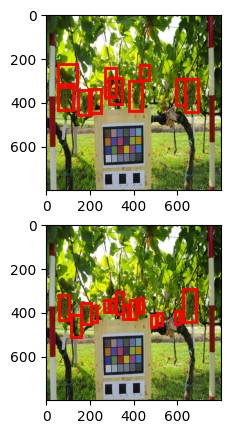

In [30]:

    # the function takes the original prediction and the iou threshold.
    def apply_nms(orig_prediction, iou_thresh=0.3):
        # torchvision returns the indices of the bboxes to keep
        keep = torchvision.ops.nms(orig_prediction['boxes'].cpu(), orig_prediction['scores'].cpu(), iou_thresh)
        
        final_prediction = orig_prediction
        final_prediction['boxes'] = final_prediction['boxes'].cpu()[keep]
        final_prediction['scores'] = final_prediction['scores'].cpu()[keep]
        final_prediction['labels'] = final_prediction['labels'].cpu()[keep]
        
        return final_prediction

    # function to convert a torchtensor back to PIL image
    test_dataset = GrapeDataset(files_dir, 800, 800,  transforms= get_transform(train=False))

    # pick one image from the test set
    img, target = test_dataset[8]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]


    print('MODEL OUTPUT\n')
    nms_prediction = apply_nms(prediction, iou_thresh=0.001)

    plot_img_bbox(img, target, nms_prediction)